# Quickly apply gravity loads and obtain mass and stiffness matrices

This document mainly introduces some model data retrieval methods in opstool.

In [1]:
import openseespy.opensees as ops

import opstool as opst
import opstool.vis.pyvista as opsvis

opsvis.set_plot_props(notebook=True)  # set notebook mode, you can set it to False for a practical use

## Model

In [2]:
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)

# Define the model nodes
ops.node(1, 0.0, 0.0)
ops.node(2, 2.0, 0.0)
ops.node(3, 0.0, 2.0)
ops.node(4, 0.0, 2.0)
ops.node(5, 2.0, 2.0)
ops.node(6, 2.0, 2.0)

# Constrain the nodes
ops.rigidLink("beam", 3, 4)  # Rigid link between nodes 3 and 4
ops.equalDOF(5, 6, 1, 2, 3)  # Equal DOF between nodes 5 and 6

ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# Assign the node masses
ops.mass(1, 1.0, 1.0, 0.0)
ops.mass(2, 1.0, 1.0, 0.0)
ops.mass(3, 1.0, 1.0, 0.0)
ops.mass(4, 1.0, 1.0, 0.0)
ops.mass(5, 10.0, 10.0, 1e-3)
ops.mass(6, 10.0, 10.0, 1e-3)

# Define the elements
ops.geomTransf("Linear", 1)

# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, <'-mass', mass>)
Area, E_mod, Iz = 1.0, 1.0, 1.0
ops.element("elasticBeamColumn", 1, 1, 3, Area, E_mod, Iz, 1, "-mass", 1.0)
ops.element("elasticBeamColumn", 2, 2, 5, Area, E_mod, Iz, 1, "-mass", 1.0)
ops.element("elasticBeamColumn", 3, 4, 6, Area, E_mod, Iz, 1, "-mass", 1.0)


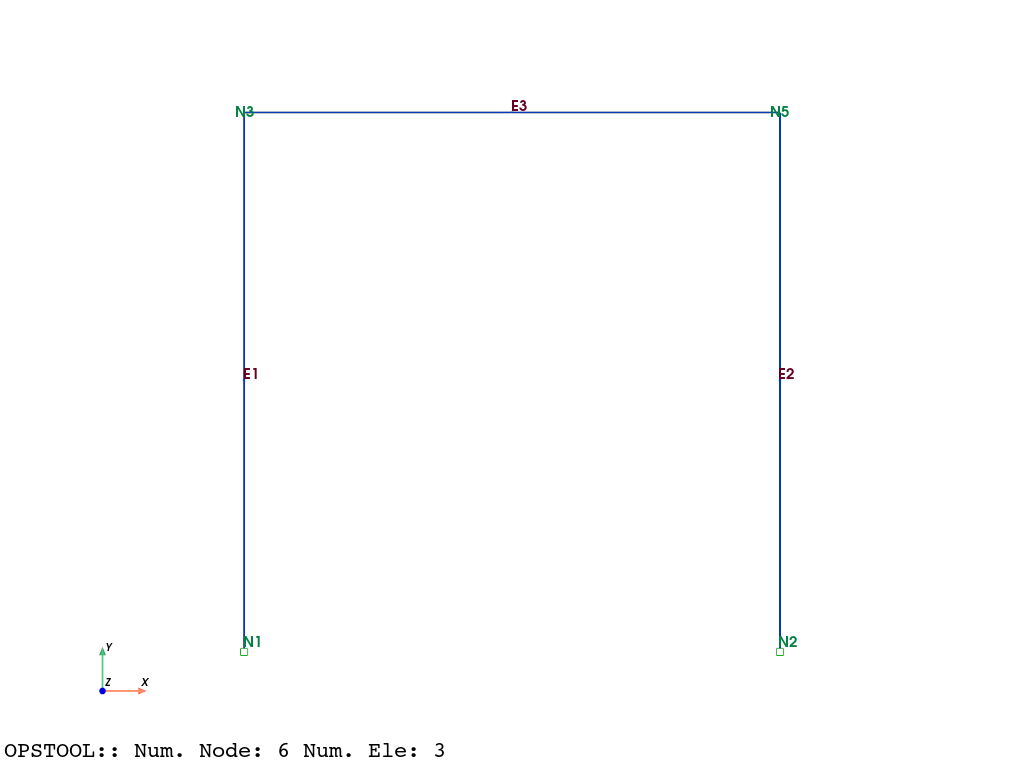

In [3]:
fig = opsvis.plot_model(show_node_numbering=True, show_ele_numbering=True)
fig.show(jupyter_backend="static")

##  Get Model Mass

``get_node_mass`` returns a dictionary containing all masses defined in the model, both at nodes and elements.

In [4]:
node_mass = opst.pre.get_node_mass()  # get the node mass dict

In [5]:
print("Node Masses:")
for node, mass in node_mass.items():
    print(f"Node {node}: {mass}")

Node Masses:
Node 1: [2.0, 2.0, 0.0]
Node 2: [2.0, 2.0, 0.0]
Node 3: [2.0, 2.0, 0.0]
Node 4: [2.0, 2.0, 0.0]
Node 5: [11.0, 11.0, 0.001]
Node 6: [11.0, 11.0, 0.001]


─── ⋆⋅☆⋅⋆ ──
✍️

▶️ First, part of it comes from

```python
ops.mass(1, 1.0, 1.0, 0.0)
ops.mass(2, 1.0, 1.0, 0.0)
ops.mass(3, 1.0, 1.0, 0.0)
ops.mass(4, 1.0, 1.0, 0.0)
ops.mass(5, 10.0, 10.0, 1e-3)
ops.mass(6, 10.0, 10.0, 1e-3)
```

▶️ The second comes from the beam elements:

``length = 2, density = 1.0, area = 1.0``

The mass assigned to each node is:

``length * density * area / 2 = 1.0``

Therefore, the returned mass is completely accurate.

### Apply the gravity load

In [6]:
ops.timeSeries("Constant", 1)  # Define a constant time series
ops.pattern("Plain", 1, 1)  # Define a load pattern
node_loads = opst.pre.create_gravity_load(direction="Y", factor=-9.81)  # Create gravity loads in the pattern 1

In [7]:
print("Node Loads:")
for node, load in node_loads.items():
    print(f"Node {node}: {load}")

Node Loads:
Node 1: [0.0, -19.62, 0.0]
Node 2: [0.0, -19.62, 0.0]
Node 3: [0.0, -19.62, 0.0]
Node 4: [0.0, -19.62, 0.0]
Node 5: [0.0, -107.91000000000001, 0.0]
Node 6: [0.0, -107.91000000000001, 0.0]


🤖 Therefore, you can easily return the mass and create gravity loads directly through the above commands. The way you specify the mass when modeling is arbitrary. opstool can help you do all the internal conversions!

## Get system matrix

You can get the mass, stiffness and damping matrix

In [8]:
constraints_args = ["Penalty", 1e10, 1e10]  # This affects the dimensions of the matrix
system_args = ["FullGeneral"]  # Full matrix system must be used
numberer_args = ["RCM"]  # It affects the topology of the matrix and the order of dof.

In [9]:
M = opst.pre.get_mck("m", constraints_args=constraints_args, system_args=system_args, numberer_args=numberer_args)
print("Mass Matrix (M):")
print(M.to_numpy().shape)

Mass Matrix (M):
(18, 18)


In [10]:
K = opst.pre.get_mck("k", constraints_args=constraints_args, system_args=system_args, numberer_args=numberer_args)
print("Stiffness Matrix (K):")
print(K.to_numpy().shape)

Stiffness Matrix (K):
(18, 18)


In [11]:
constraints_args = ["Transformation"]  # This affects the dimensions of the matrix
system_args = ["FullGeneral"]  # Full matrix system must be used
numberer_args = ["Plain"]  # It affects the topology of the matrix and the order of dof.

In [12]:
K = opst.pre.get_mck("k", constraints_args=constraints_args, system_args=system_args, numberer_args=numberer_args)
print("Stiffness Matrix (K):")
print(K.to_numpy())

Stiffness Matrix (K):
[[ 2.   0.   1.5 -0.5  0.   0. ]
 [ 0.   2.   1.5  0.  -1.5  1.5]
 [ 1.5  1.5  4.   0.  -1.5  1. ]
 [-0.5  0.   0.   2.   0.   1.5]
 [ 0.  -1.5 -1.5  0.   2.  -1.5]
 [ 0.   1.5  1.   1.5 -1.5  4. ]]
